## Relation between Earnings Call & Stock Prices

In [278]:
# yfinance no financial data
import pandas as pd
import yfinance as yf
# write a function to get the financial statement data
def get_financial(ticker):
    data = yf.Ticker(ticker)
    return data.financials
# write a function to get the balance sheet data
def get_balance(ticker):
    data = yf.Ticker(ticker)
    return data.balance_sheet
# write a function to get the cash flow data
def get_cash(ticker):
    data = yf.Ticker(ticker)
    return data.cashflow
# write a function to get the income statement data
def get_income(ticker):
    data = yf.Ticker(ticker)
    return data.quarterly_financials
def get_info(ticker):
    data = yf.Ticker(ticker)
    return data.info

In [279]:
# write an function to get the stock price from yfinance
def get_data(ticker, period):
    data = yf.download(ticker, period=period)
    data.reset_index(inplace=True)
    data["Date"] = data["Date"].astype(str)
    return data
get_data("AAPL", "5y")

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-04-23,41.707500,41.730000,41.022499,41.310001,39.381702,146062000
1,2018-04-24,41.417500,41.582500,40.305000,40.735001,38.833538,134768000
2,2018-04-25,40.654999,41.355000,40.602501,40.912498,39.002747,113528400
3,2018-04-26,41.029999,41.432499,40.842499,41.055000,39.138599,111852000
4,2018-04-27,41.000000,41.082500,40.157501,40.580002,38.685768,142623200
...,...,...,...,...,...,...,...
1253,2023-04-14,164.589996,166.320007,163.820007,165.210007,165.210007,49337200
1254,2023-04-17,165.089996,165.389999,164.029999,165.229996,165.229996,41516200
1255,2023-04-18,166.100006,167.410004,165.649994,166.470001,166.470001,49923000
1256,2023-04-19,165.800003,168.160004,165.539993,167.630005,167.630005,47720200


In [280]:
def get_earnings_dates(ticker):
    stock = yf.Ticker(ticker) # yfinance.Ticker object <TSLA>
    earnings_dates = stock.earnings_dates.rename_axis('Earnings Date').reset_index().sort_values(by=['Earnings Date'])
    # earnings_dates = tsla.earnings_dates.sort_values(by=['Earnings Date'])
    earnings_dates['Earnings Date'] = earnings_dates['Earnings Date'].apply(lambda x:str(x).split(' ')[0])
    earnings_dates.rename({'Earnings Date': 'Date'}, axis=1, inplace=True)
    return earnings_dates
get_earnings_dates("TSLA")

,Date,EPS Estimate,Reported EPS,Surprise(%)
11,2021-10-20,0.53,0.62,0.1668
10,2022-01-26,0.79,0.85,0.0715
9,2022-04-20,0.75,1.07,0.4256
8,2022-07-20,0.60,0.76,0.2511
7,2022-10-19,0.99,1.05,0.0570
6,2023-01-25,1.13,1.19,0.0555
5,2023-04-19,0.85,0.85,NaN
4,2023-07-18,0.91,NaN,NaN
3,2023-10-17,NaN,NaN,NaN
2,2024-01-23,NaN,NaN,NaN


In [281]:
# merge the two dataframes
import math
def merge(ticker,period):
    stock_data = get_data(ticker, period)
    earnings_dates = get_earnings_dates(ticker)
    result = pd.merge(stock_data, earnings_dates, on='Date')
    result["Surprise(%)"] = result["Surprise(%)"].apply(lambda x: math.trunc(1000 * x) / 1000 if (type(x) == float and not math.isnan(x)) else 0)
    return result
merge("TSLA","1y")

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,EPS Estimate,Reported EPS,Surprise(%)
0,2022-07-20,246.783340,250.663330,243.483337,247.500000,247.500000,88864200,0.60,0.76,0.251
1,2022-10-19,219.800003,222.929993,217.779999,222.039993,222.039993,66571500,0.99,1.05,0.057
2,2023-01-25,141.910004,146.410004,138.070007,144.429993,144.429993,192734300,1.13,1.19,0.055
3,2023-04-19,179.100006,183.500000,177.649994,180.589996,180.589996,125732700,0.85,0.85,0.000


In [282]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_chart(ticker, period):
    fig1, ax3 = plt.subplots(figsize=(20, 10))
    ax1 = ax3.twinx()
    ax2 = ax1.twinx()
    
    prices = get_data(ticker, period)
    prices['Date'] = pd.to_datetime(prices['Date'])  # convert to datetime format
    ax1.plot(prices['Date'], prices['Open'], 'b-')
    ax2.plot(prices['Date'], prices['Close'], 'r-')

    result = merge(ticker, period)
    important_dates = pd.to_datetime(result['Date'])
    for date in important_dates:
        ax3.axvline(x=date, color='k', linestyle='--')
        # ax3.text(date, ax3.get_ylim()[1], result.loc[result['Date']==str(date.date()), 'Date'].values[0], 
        #          rotation=90, verticalalignment='bottom', horizontalalignment='center')
        ax3.text(date, ax3.get_ylim()[1], result.loc[result['Date']==str(date.date()), 'Surprise(%)'].values[0], 
                 rotation=90, verticalalignment='bottom', horizontalalignment='center')
        
    ax1.set_ylabel('Open Price', color='b')
    ax2.set_ylabel('Close Price', color='r')
    # ax3.set_xlabel('Earning Call Dates')
    ax3.set_title(ticker, loc='left') # set title
    
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax3.set_xlim(ax1.get_xlim())  # set the same x-limits as ax1

    ax3.set_yticklabels([])
    
    fig1.autofmt_xdate()  # rotate and space out x-axis labels
    fig1.tight_layout()  # align and space out subplots

    plt.savefig('plot.jpg') # save plot as JPG file

    plt.show()
    return plt

## TSLA

          Date  EPS Estimate  Reported EPS  Surprise(%)
11  2021-10-20          0.53          0.62       0.1668
10  2022-01-26          0.79          0.85       0.0715
9   2022-04-20          0.75          1.07       0.4256
8   2022-07-20          0.60          0.76       0.2511
7   2022-10-19          0.99          1.05       0.0570
6   2023-01-25          1.13          1.19       0.0555
5   2023-04-19          0.85          0.85          NaN
4   2023-07-18          0.91           NaN          NaN
3   2023-10-17           NaN           NaN          NaN
2   2024-01-23           NaN           NaN          NaN
1   2024-01-23           NaN           NaN          NaN
0   2024-04-17           NaN           NaN          NaN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


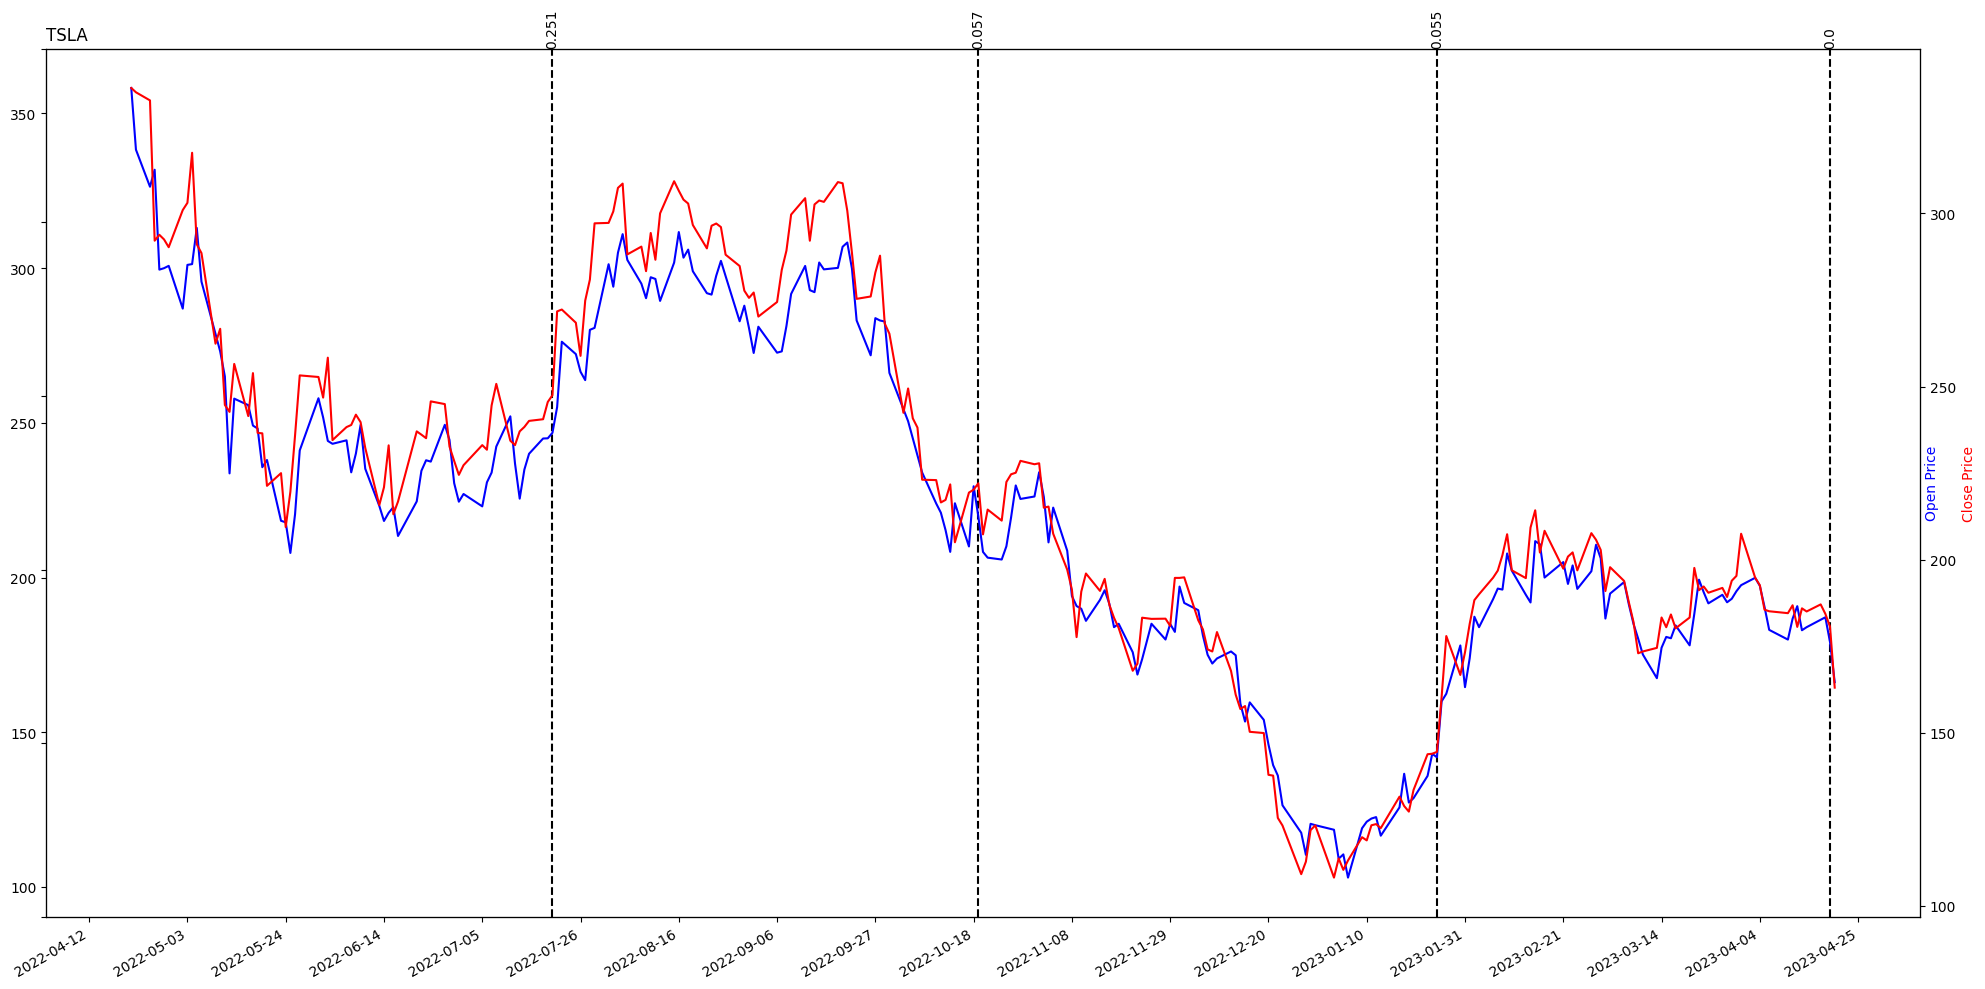

<module 'matplotlib.pyplot' from '/Users/beckyliu/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

In [283]:
print(get_earnings_dates("TSLA"))
plot_chart("TSLA","1y")

## AAPL

          Date  EPS Estimate  Reported EPS  Surprise(%)
11  2021-10-28          1.24          1.24       0.0030
10  2022-01-27          1.89          2.10       0.1117
9   2022-04-28          1.43          1.52       0.0644
8   2022-07-28          1.16          1.20       0.0325
7   2022-10-27          1.27          1.29       0.0155
6   2023-02-02          1.94          1.88      -0.0288
5   2023-05-04          1.43           NaN          NaN
4   2023-05-04          1.43           NaN          NaN
3   2023-07-26           NaN           NaN          NaN
2   2023-10-25           NaN           NaN          NaN
1   2024-01-31           NaN           NaN          NaN
0   2024-01-31           NaN           NaN          NaN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


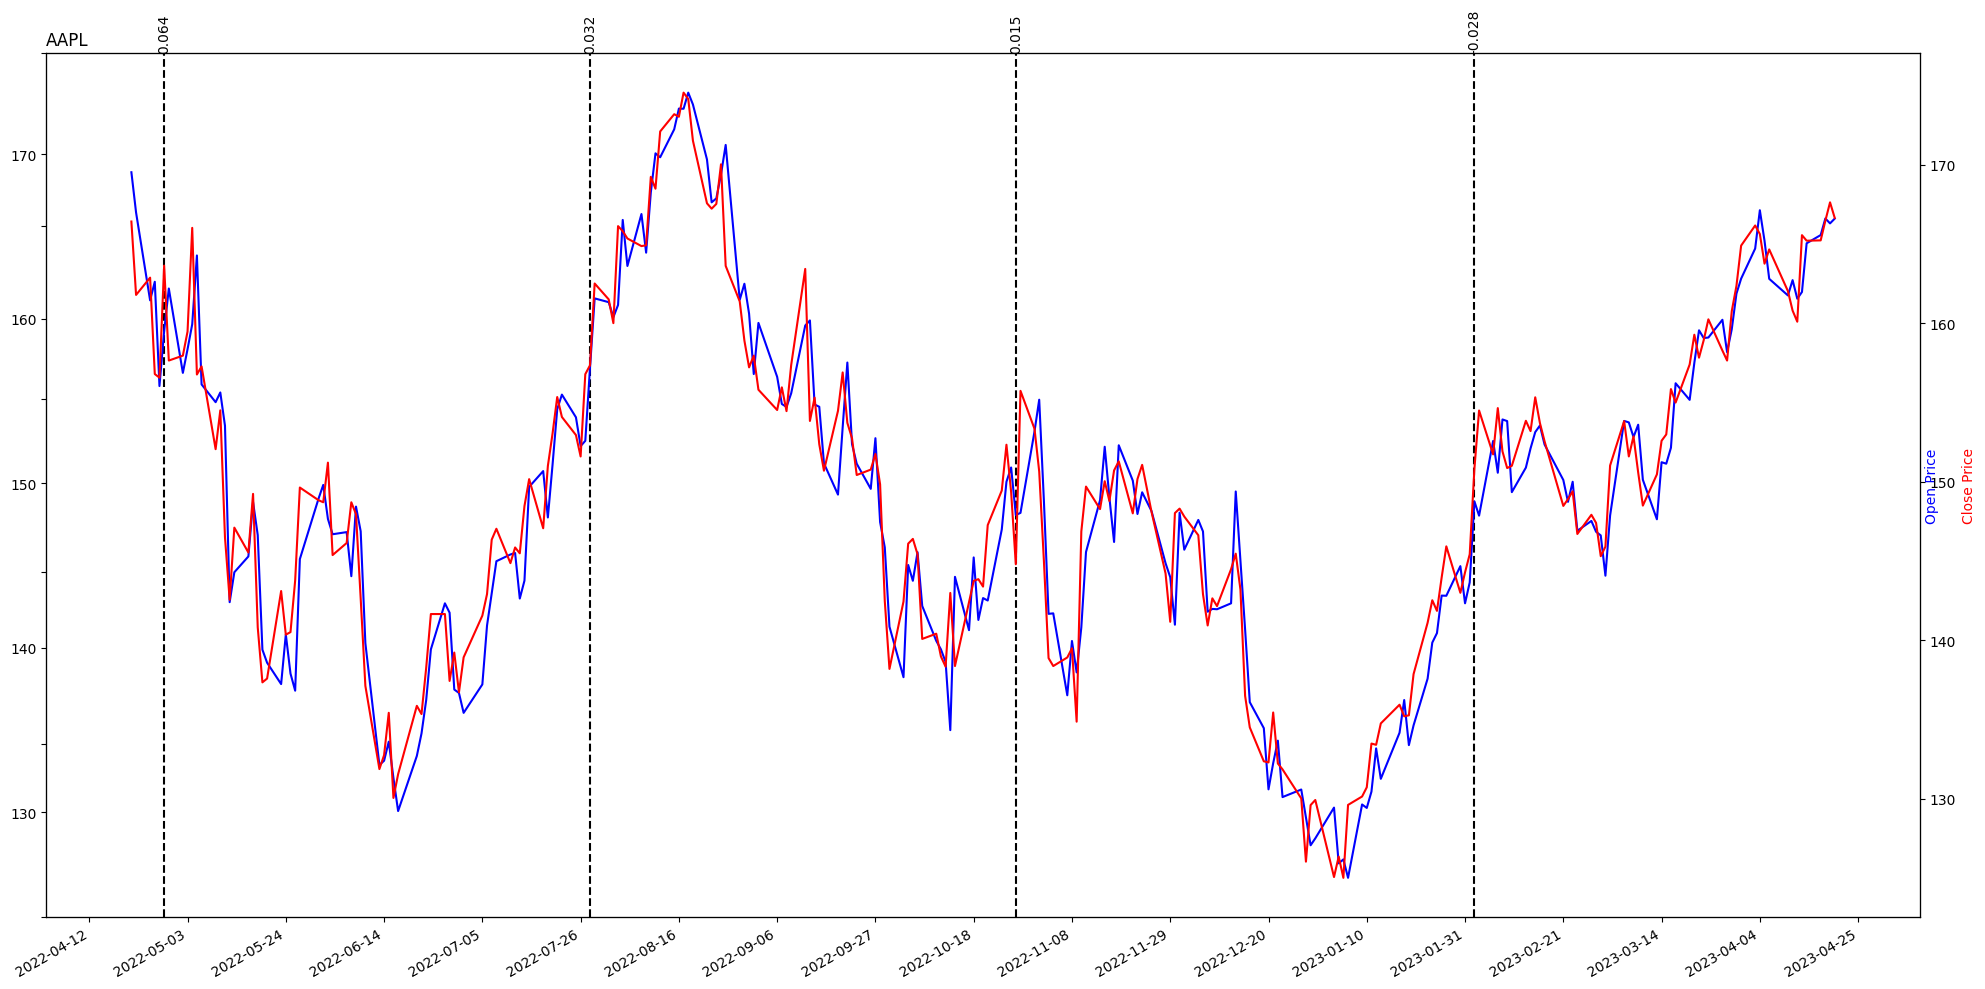

<module 'matplotlib.pyplot' from '/Users/beckyliu/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

In [284]:
print(get_earnings_dates("AAPL"))
plot_chart("AAPL","1y")

## NVDA

          Date  EPS Estimate  Reported EPS  Surprise(%)
11  2021-05-26          0.82          0.92       0.1146
10  2021-08-18          1.01          1.04       0.0251
9   2021-11-17          1.11          1.17       0.0576
8   2022-02-16          1.22          1.32       0.0799
7   2022-05-25          1.29          1.36       0.0515
6   2022-08-24          1.26          0.51      -0.5938
5   2022-11-16          0.69          0.58      -0.1647
4   2023-02-22          0.81          0.88       0.0875
3   2023-05-24          0.91           NaN          NaN
2   2023-08-22           NaN           NaN          NaN
1   2023-11-14           NaN           NaN          NaN
0   2024-02-20           NaN           NaN          NaN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


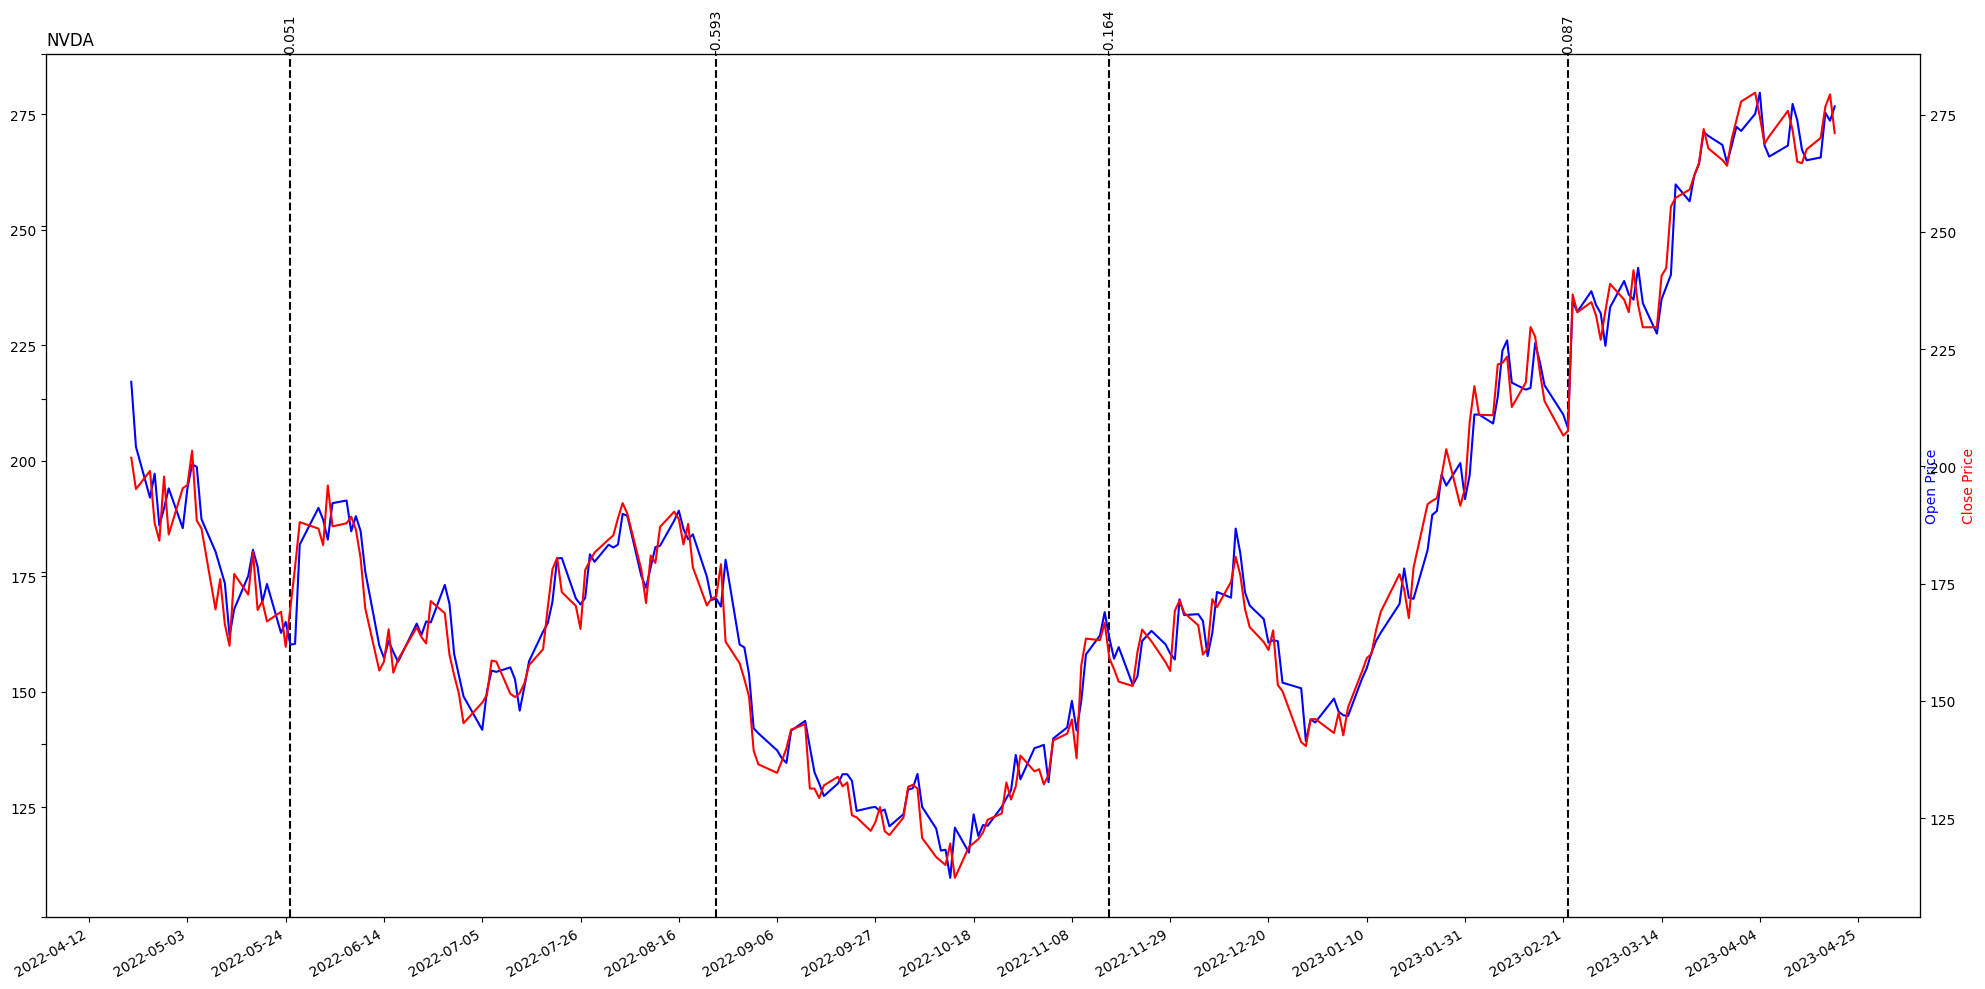

<module 'matplotlib.pyplot' from '/Users/beckyliu/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

In [285]:
print(get_earnings_dates("NVDA"))
plot_chart("NVDA","1y")

# Appendix

In [286]:
# alternative API: yahooquery
# https://yahooquery.dpguthrie.com/guide/ticker/modules/
from yahooquery import Ticker

tsla = Ticker('tsla')
tsla.financial_data["tsla"]
tsla.earning_history
earnings = tsla.earning_history[["epsActual","epsEstimate","epsDifference","quarter"]]
earnings


epsActual  epsEstimate  epsDifference     quarter
symbol row                                                   
tsla   0         0.76         0.60           0.16  2022-06-30
       1         1.05         0.99           0.06  2022-09-30
       2         1.19         1.13           0.06  2022-12-31
       3         0.85         0.85           0.00  2023-03-31

In [287]:
tsla.calendar_events

{'tsla': {'maxAge': 1,
  'earnings': {'earningsDate': ['2023-07-18 16:00:S', '2023-07-24 16:00:S'],
   'earningsAverage': 0.91,
   'earningsLow': 0.78,
   'earningsHigh': 1.1,
   'revenueAverage': 24757900000,
   'revenueLow': 21760000000,
   'revenueHigh': 26314000000}}}